# Лабораторная работа №2
### Выполнила Рындина Валерия, M33351

In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as LA

## Алгоритмы

### МНК


In [2]:
def mnk(x, y, tau):
    _, n = x.shape
    # V, D, U_t = LA.svd(x)
    # # V_t = np.transpose(V)
    # # U = np.transpose(U_t)
    # fi = sum(D[i] / (D[i] ** 2 + tau) * V[i] * U_t.dot(y).sum() for i in range(n))
    # return  fi
    return np.matmul(
        np.matmul(
            np.linalg.inv(np.matmul(np.transpose(x), x) + tau * np.identity(n)),
            np.transpose(x)
        ),
        y
    )


### градиентный спуск

In [3]:
def mse(y, y_pred):
    return (y + y_pred) ** 2

def diff_mse(y, y_pred):
    return 2.0 * (y_pred - y)

In [4]:
def smape(y, y_pred):
    return 1.0 * abs(y - y_pred) / (abs(y) + abs(y_pred))

def diff_smape(y, y_pred):
    return np.sign(y_pred - y) * (abs(y) + abs(y_pred) - np.sign(y_pred) * (y_pred - y)) / (
            (abs(y) + abs(y_pred)) ** 2)

In [5]:
def stochastic_gradient(x, y, diff_L, tau, mu, metric):
    n = len(x)
    w = [1 / (2 * n) for _ in range(len(x[0]))]

    metric_vals = list()
    metric_val = 1.
    alpha = 1 / 100

    for i in range(1000):
        step = 1.0 / (i + 1)

        diff_multiplier = diff_L(y[i % n], np.dot(w, x[i % n]))
        diff = list(x_i * diff_multiplier for x_i in x[i % n])
        diff_tau = list(diff_i + tau * x_i for x_i, diff_i in zip(x[i % n], diff))

        t = list(w_i - d_tau_i * step - mu * d_i for w_i, d_tau_i, d_i in zip(w, diff_tau, diff))

        new_metric = sum(metric(y, np.dot(x, w))) /n
        metric_val = (1 - alpha) * metric_val + alpha * new_metric
        metric_vals.append(metric_val)
        w = t
    #   L = (1 - alpha) L + alpha * L(np.dot(w, x[i]) * y[i])
    return w, metric_vals

## Настройка

In [6]:
# normalize
def normalize(dt):
    for col in dt.columns :
        min_val = min(dt[col])
        max_val = max(dt[col])
        dt[col] = dt[col].apply(lambda x: (x - min_val) / (max_val - min_val) if max_val != min_val else 0.0)

In [35]:
with open('data/3.txt', 'r') as f:
    n = int(f.readline())

    n_train = int(f.readline())
    x_train = pd.DataFrame(map(lambda it: map(int, it.split(' ')), list(f.readline() for _ in range(n_train))))

    n_test = int(f.readline())
    x_test = pd.DataFrame(map(lambda it: map(int, it.split(' ')), list(f.readline() for _ in range(n_test))))

normalize(x_train)
y_train = x_train[n]
x_train = x_train.drop(columns=n)

normalize(x_test)
y_test = x_test[n]
x_test = x_test.drop(columns=n)

x_train.head()
x_test.head()

,0,1,2,3,4,5,6,7,8
0,0.797509,0.202492,0.0,0.202491,0.0,0.202491,0.202491,0.797509,0.0
1,0.160068,0.839934,0.0,0.839932,0.0,0.839932,0.839932,0.160068,0.0
2,0.419145,0.580854,0.0,0.580855,0.0,0.580855,0.580855,0.419145,0.0
3,0.270965,0.729036,0.0,0.729035,0.0,0.729034,0.729035,0.270965,0.0
4,0.506731,0.493270,0.0,0.493269,0.0,0.493269,0.493269,0.506731,0.0


In [8]:
import optuna

def objective_mnk(trial, error_fun):
    tau = trial.suggest_uniform("tau", 0, 1)

    w = mnk(x_train, y_train, tau)
    return error_fun(w)

def objective_gradient(trial, diff_fun, error_fun, metric):
    tau = trial.suggest_uniform("tau", 0, 10)
    mu = trial.suggest_uniform("alpha", 0.1, 0.9)

    w, _ = stochastic_gradient(x_train, y_train, diff_fun, tau, mu, metric)
    return error_fun(w)

def error(x, y, error_fun):
    def inner(weights):
        pred = np.dot(weights, x)
        return sum(error_fun(y_i, p_i) for p_i, y_i in zip(pred, y)) / len(x)
    return inner

In [9]:
studyMNK = optuna.create_study(direction='minimize')
studyMNK.optimize(lambda trial : objective_mnk(trial, error(x_train, y_train, smape)), n_trials=100)

print('Testing MNK')
print('Number of finished trials:', len(studyMNK.trials))
print('Best trial:', studyMNK.best_trial.params)
print('Best score:', studyMNK.best_trial.value)

[I 2022-05-25 18:32:13,140] A new study created in memory with name: no-name-8a4b47fa-90e6-4c9b-85bf-09ee4e1787f4
[I 2022-05-25 18:32:13,404] Trial 0 finished with value: 0.5829443500287073 and parameters: {'tau': 0.24952012841993654}. Best is trial 0 with value: 0.5829443500287073.
[I 2022-05-25 18:32:13,408] Trial 1 finished with value: 0.5832017952270385 and parameters: {'tau': 0.31518995333452926}. Best is trial 0 with value: 0.5829443500287073.
[I 2022-05-25 18:32:13,414] Trial 2 finished with value: 0.5847849999053873 and parameters: {'tau': 0.741657565937292}. Best is trial 0 with value: 0.5829443500287073.
[I 2022-05-25 18:32:13,418] Trial 3 finished with value: 0.5825308306613608 and parameters: {'tau': 0.14605099691885826}. Best is trial 3 with value: 0.5825308306613608.
[I 2022-05-25 18:32:13,428] Trial 4 finished with value: 0.5831682672238144 and parameters: {'tau': 0.3065820709074044}. Best is trial 3 with value: 0.5825308306613608.
[I 2022-05-25 18:32:13,440] Trial 5 fin

Testing MNK
Number of finished trials: 100
Best trial: {'tau': 0.00010910164996842837}
Best score: 0.5819309179640789


In [10]:
studyMSE = optuna.create_study(direction='minimize')
studyMSE.optimize(lambda trial : objective_gradient(trial, diff_mse, error(x_train, y_train, mse), mse), n_trials=100)


print('Testing MSE gradient')
print('Number of finished trials:', len(studyMSE.trials))
print('Best trial:', studyMSE.best_trial.params)
print('Best score:', studyMSE.best_trial.value)

[I 2022-05-25 18:32:15,065] A new study created in memory with name: no-name-86ff14b5-8cad-4862-9c5c-88bb6f76557c
/tmp/ipykernel_26423/1019279531.py:13: RuntimeWarning: invalid value encountered in double_scalars
  diff = list(x_i * diff_multiplier for x_i in x[i % n])
[W 2022-05-25 18:32:15,368] Trial 0 failed, because the objective function returned nan.
/tmp/ipykernel_26423/1618380470.py:2: RuntimeWarning: overflow encountered in double_scalars
  return (y + y_pred) ** 2
[I 2022-05-25 18:32:15,663] Trial 1 finished with value: inf and parameters: {'tau': 2.909191428985637, 'alpha': 0.6497170010179221}. Best is trial 1 with value: inf.
[I 2022-05-25 18:32:15,952] Trial 2 finished with value: 0.9958594159709863 and parameters: {'tau': 6.710102003818958, 'alpha': 0.12477564310244978}. Best is trial 2 with value: 0.9958594159709863.
/tmp/ipykernel_26423/1618380470.py:2: RuntimeWarning: overflow encountered in double_scalars
  return (y + y_pred) ** 2
[I 2022-05-25 18:32:16,217] Trial 3 

Testing MSE gradient
Number of finished trials: 100
Best trial: {'tau': 7.4167290475337255, 'alpha': 0.10219946173782557}
Best score: 0.9640725458354191


In [11]:
studySMAPE = optuna.create_study(direction='minimize')
studySMAPE.optimize(lambda trial : objective_gradient(trial, diff_smape, error(x_train, y_train, smape), smape), n_trials=100)

print('Testing SMAPE gradient')
print('Number of finished trials:', len(studySMAPE.trials))
print('Best trial:', studySMAPE.best_trial.params)
print('Best score:', studySMAPE.best_trial.value)

[I 2022-05-25 18:32:45,763] A new study created in memory with name: no-name-18cc455b-8aec-4541-9792-f05fceb94ef7
[I 2022-05-25 18:32:46,607] Trial 0 finished with value: 1.0 and parameters: {'tau': 5.211108678983783, 'alpha': 0.6722432213272935}. Best is trial 0 with value: 1.0.
[I 2022-05-25 18:32:47,347] Trial 1 finished with value: 1.0 and parameters: {'tau': 3.534641257206408, 'alpha': 0.833033402591652}. Best is trial 0 with value: 1.0.
[I 2022-05-25 18:32:48,022] Trial 2 finished with value: 1.0 and parameters: {'tau': 2.7542441472505477, 'alpha': 0.7966288178333027}. Best is trial 0 with value: 1.0.
[I 2022-05-25 18:32:48,595] Trial 3 finished with value: 1.0 and parameters: {'tau': 0.656539404308274, 'alpha': 0.48903504355728844}. Best is trial 0 with value: 1.0.
[I 2022-05-25 18:32:49,200] Trial 4 finished with value: 1.0 and parameters: {'tau': 5.947251442082986, 'alpha': 0.7549358207603288}. Best is trial 0 with value: 1.0.
[I 2022-05-25 18:32:49,623] Trial 5 finished with 

Testing SMAPE gradient
Number of finished trials: 100
Best trial: {'tau': 0.05020946376592769, 'alpha': 0.15342193085480144}
Best score: 0.5615478155238243


## Тестирование

### График зависимости ошибки SMAPE и MSE на тестовом множестве от параметра регуляризации для метода наименьших квадратов

In [13]:
smapeList = []
mseList = []
for i in range(1, 100):
    w = mnk(x_train, y_train, 1 / i)
    mse_err = sum(sum(mse(y, np.dot(x, w)) for x, y in zip(x_test, y_test))) / len(x_test)
    smape_err = sum(sum(smape(y, np.dot(x, w)) for x, y in zip(x_test, y_test))) / len(x_test)
    smapeList.append(smape_err)
    mseList.append(mse_err)

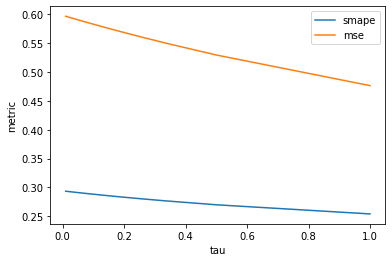

In [14]:
from matplotlib import pyplot as plt

plt.plot([1 / i for i in range(1, 100)], smapeList, label='smape')
plt.plot([1 / i for i in range(1, 100)], mseList, label='mse')
plt.legend()
plt.ylabel("metric")
plt.xlabel("tau")
plt.show()

### график зависимости экспоненциального скользящего среднего эмпирического риска на тренировочном множестве для градиентных спусков

In [15]:
_, w_mse = stochastic_gradient(x_train, y_train, diff_mse, studyMSE.best_trial.params['tau'], studyMSE.best_trial.params['alpha'], mse)
_, w_smape = stochastic_gradient(x_train, y_train, diff_smape, studySMAPE.best_trial.params['tau'], studySMAPE.best_trial.params['alpha'], smape)


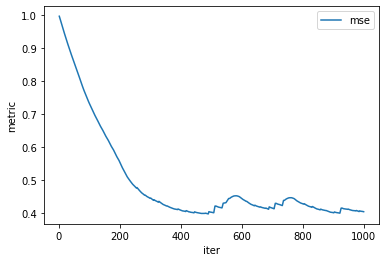

In [16]:
plt.plot([i + 1 for i in range(0, len((w_smape)))], w_smape, label='mse')
plt.legend()
plt.ylabel("metric")
plt.xlabel("iter")
plt.show()

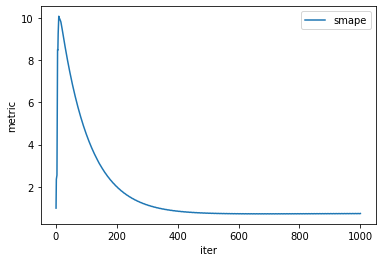

In [17]:
plt.plot([i + 1 for i in range(0, len(w_mse))], w_mse, label='smape')
plt.legend()
plt.ylabel("metric")
plt.xlabel("iter")
plt.show()

### Оцените каждый из трёх методов на тестовом множестве данных при помощи NRMSE и SMAPE

In [40]:
import math

def nrmse_methods(w):
    ans = 0
    y_max = np.max(y_test)
    y_min = np.min(y_test)
    for i in range(len(x_test)):
        actual = np.dot(x_test.iloc[i], w)
        ans += (actual - y_test[i]) ** 2
    return math.sqrt(ans / len(x_test)) / (y_max - y_min)


def smape_methods(w):
    return sum(sum(smape(y, np.dot(x, w)) for x, y in zip(x_test, y_test))) / len(x_test)

In [41]:
w_mnk = mnk(x_train, y_train, studyMNK.best_trial.params['tau'])
w_mse, _ = stochastic_gradient(x_train, y_train, diff_mse, studyMSE.best_trial.params['tau'], studyMSE.best_trial.params['alpha'], mse)
w_smape, _ = stochastic_gradient(x_train, y_train, diff_smape, studySMAPE.best_trial.params['tau'], studySMAPE.best_trial.params['alpha'], smape)

print('MNK: SMAPE: ', smape_methods(w_mnk) , ', NRMSE:', nrmse_methods(w_mnk))
print('MSE: SMAPE: ', smape_methods(w_mse) , ', NRMSE:', nrmse_methods(w_mse))
print('SMAPE: SMAPE: ', smape_methods(w_smape) , ', NRMSE:', nrmse_methods(w_smape))

MNK: SMAPE:  0.2940588481464574 , NRMSE: 0.0002586782917400415
MSE: SMAPE:  0.1992947191403588 , NRMSE: 0.26943824289774304
SMAPE: SMAPE:  0.09220725690123495 , NRMSE: 0.2583796752650631
